In [ ]:
### Importaciones y librerías

In [47]:
import os
import pandas as pd
import SimpleITK as sitk
import pydicom
import matplotlib.pyplot as plt
import ipywidgets 
import nibabel as nib
import numpy as np
import sys
import re
import glob

from datetime import datetime
from IPython.display import display
from radiomics import featureextractor
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve,classification_report, auc, ConfusionMatrixDisplay,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier




In [ ]:
### Ruta Base

Todas las rutas de este Notebook deberán ser modificadas para su utilización

In [6]:
ruta_base = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT"

In [ ]:
### Listados de Pacientes del Dataset RIDER

Se toma información de todos los pacientes y se leen las imágenes por fecha para cada uno de ellos.

In [7]:
pacientes = [p for p in os.listdir(ruta_base) if os.path.isdir(os.path.join(ruta_base, p))]

print(f"Se encontraron {len(pacientes)} pacientes.\n")

for paciente in pacientes[:1]: 
    print(f"📁 Paciente: {paciente}")
    paciente_path = os.path.join(ruta_base, paciente)
    estudios = os.listdir(paciente_path)
    for estudio in estudios:
        print(f"  📅 Estudio: {estudio}")
        estudio_path = os.path.join(paciente_path, estudio)
        if os.path.isdir(estudio_path):
            series = os.listdir(estudio_path)
            for serie in series:
                print(f"    ➤ Serie: {serie}")
    print("-" * 60)

Se encontraron 32 pacientes.

📁 Paciente: RIDER-1129164940
  📅 Estudio: 09-05-2006-NA-NA-04592
    ➤ Serie: 1.000000-NA-99761
    ➤ Serie: 100.000000-NA-08284
    ➤ Serie: 101.000000-NA-69305
    ➤ Serie: 103.000000-NA-95493
    ➤ Serie: 104.000000-NA-04980
    ➤ Serie: 2.000000-NA-73678
    ➤ Serie: 2.000000-Tumor Segmentation-85043
    ➤ Serie: 3.000000-NA-93064
    ➤ Serie: 3.000000-Tumor Segmentation-51791
  📅 Estudio: 09-19-2006-NA-NA-88216
    ➤ Serie: 1.000000-NA-90120
    ➤ Serie: 10.000000-NA-82412
    ➤ Serie: 10.000000-Tumor Segmentation-84466
    ➤ Serie: 100.000000-NA-18882
    ➤ Serie: 100.000000-Tumor Segmentation-01562
    ➤ Serie: 101.000000-NA-34708
    ➤ Serie: 101.000000-Tumor Segmentation-43650
    ➤ Serie: 102.000000-NA-60184
    ➤ Serie: 103.000000-NA-53899
    ➤ Serie: 103.000000-Tumor Segmentation-65460
    ➤ Serie: 104.000000-NA-36735
    ➤ Serie: 104.000000-Tumor Segmentation-58588
    ➤ Serie: 105.000000-NA-35324
    ➤ Serie: 105.000000-Tumor Segmentation-97

In [12]:
### Ordenar estudios por fecha 

Con intención de localizar posibles imágenes de PRE-POST tratamiento se ordenan todas las imágenes y por consecuente los pacientes por fecha. Se categorizan esos posibles conjuntos de datos por lo que llamamos Fases

In [10]:
def ordenar_estudios_por_fecha(paciente_path):
    estudios = []
    for carpeta in os.listdir(paciente_path):
        try:
            fecha_str = "-".join(carpeta.split("-")[0:3])
            fecha = datetime.strptime(fecha_str, "%m-%d-%Y")
            estudios.append((fecha, carpeta))
        except Exception as e:
            print(f"❌ Error procesando {carpeta}: {e}")
    estudios.sort()
    return estudios  

In [9]:
pacientes_fases = {}

for paciente in pacientes:
    ruta_paciente = os.path.join(ruta_base, paciente)
    if not os.path.isdir(ruta_paciente):
        continue
    estudios_ordenados = ordenar_estudios_por_fecha(ruta_paciente)
    if len(estudios_ordenados) < 2:
        print(f"⚠️ Paciente {paciente} no tiene suficientes estudios.")
        continue
    pacientes_fases[paciente] = {
        "fase_1": estudios_ordenados[0][1],
        "fase_2": estudios_ordenados[-1][1]
    }

print(f"Pacientes procesados: {len(pacientes_fases)}\n")
for p, fases in list(pacientes_fases.items()):
    print(f"🧍 {p}")
    print(f"   Fase 1: {fases['fase_1']}")
    print(f"   Fase 2: {fases['fase_2']}")

Pacientes procesados: 32

🧍 RIDER-1129164940
   Fase 1: 09-05-2006-NA-NA-04592
   Fase 2: 10-24-2006-NA-NA-40065
🧍 RIDER-1225316081
   Fase 1: 01-30-2007-NA-NA-56138
   Fase 2: 01-30-2007-NA-NA-58990
🧍 RIDER-1286684383
   Fase 1: 02-26-2007-NA-NA-83116
   Fase 2: 02-26-2007-NA-NA-85682
🧍 RIDER-1332496276
   Fase 1: 01-28-2007-1-NA-14132
   Fase 2: 01-28-2007-NA-NA-65863
🧍 RIDER-1344011628
   Fase 1: 01-26-2007-NA-NA-00365
   Fase 2: 01-26-2007-NA-NA-95028
🧍 RIDER-1346917136
   Fase 1: 08-12-2006-NA-NA-50774
   Fase 2: 09-21-2006-NA-NA-35146
🧍 RIDER-1500037140
   Fase 1: 08-20-2006-NA-NA-30708
   Fase 2: 08-21-2006-NA-NA-53749
🧍 RIDER-1532432635
   Fase 1: 04-11-2007-NA-NA-74649
   Fase 2: 04-12-2007-NA-NA-05084
🧍 RIDER-1760553574
   Fase 1: 04-22-2007-NA-NA-76866
   Fase 2: 04-23-2007-NA-NA-41616
🧍 RIDER-1801720707
   Fase 1: 01-11-2007-NA-NA-80237
   Fase 2: 01-11-2007-NA-NA-95994
🧍 RIDER-1825099523
   Fase 1: 11-14-2006-NA-NA-71455
   Fase 2: 11-15-2006-NA-NA-22221
🧍 RIDER-1867199702

Se configura un DataSet que recopila toda la información de los 32 pacientes y sus imágenes. Se tiene un total de 936 imágenes.

In [11]:
estructura_dataset = []

for paciente in pacientes:
    ruta_paciente = os.path.join(ruta_base, paciente)
    if not os.path.isdir(ruta_paciente):
        continue
    for estudio in os.listdir(ruta_paciente):
        ruta_estudio = os.path.join(ruta_paciente, estudio)
        if not os.path.isdir(ruta_estudio):
            continue 
        for serie in os.listdir(ruta_estudio):
            ruta_serie = os.path.join(ruta_estudio, serie)
            if not os.path.isdir(ruta_serie):
                continue

            tipo = "CT" if "NA" in serie else "Máscara" if "Segmentation" in serie or "Tumor" in serie else "Otro"
            
            estructura_dataset.append({
                "Paciente": paciente,
                "Estudio": estudio,
                "Serie": serie,
                "Tipo": tipo,
                "Ruta completa": ruta_serie
            })

df_estructura = pd.DataFrame(estructura_dataset)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
display(df_estructura) 


,Paciente,Estudio,Serie,Tipo,Ruta completa
0,RIDER-1129164940,09-05-2006-NA-NA-04592,1.000000-NA-99761,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\1.000000-NA-99761
1,RIDER-1129164940,09-05-2006-NA-NA-04592,100.000000-NA-08284,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\100.000000-NA-08284
2,RIDER-1129164940,09-05-2006-NA-NA-04592,101.000000-NA-69305,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\101.000000-NA-69305
3,RIDER-1129164940,09-05-2006-NA-NA-04592,103.000000-NA-95493,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\103.000000-NA-95493
4,RIDER-1129164940,09-05-2006-NA-NA-04592,104.000000-NA-04980,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\104.000000-NA-04980
...,...,...,...,...,...
931,RIDER-9763310455,09-15-2006-NA-NA-97831,3.000000-Tumor Segmentation-02667,Máscara,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-9763310455\09-15-2006-NA-NA-97831\3.000000-Tumor Segmentation-02667
932,RIDER-9763310455,09-15-2006-NA-NA-97831,4.000000-NA-19811,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-9763310455\09-15-2006-NA-NA-97831\4.000000-NA-19811
933,RIDER-9763310455,09-15-2006-NA-NA-97831,4.000000-Tumor Segmentation-33225,Máscara,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-9763310455\09-15-2006-NA-NA-97831\4.000000-Tumor Segmentation-33225
934,RIDER-9763310455,09-16-2006-NA-NA-10767,101.000000-NA-01116,CT,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-9763310455\09-16-2006-NA-NA-10767\101.000000-NA-01116


In [ ]:
### Analizar DataSet por series de imágenes CT

In [12]:
def analizar_series_por_fase(df_estructura, ruta_base):
    resumen = []
    for paciente in df_estructura['Paciente'].unique():
        df_paciente = df_estructura[df_estructura['Paciente'] == paciente]
        fechas_estudios = df_paciente['Estudio'].unique()
        fechas_ordenadas = sorted(
            fechas_estudios,
            key=lambda x: datetime.strptime("-".join(x.split("-")[0:3]), "%m-%d-%Y")
        )
        if len(fechas_ordenadas) < 2:
            continue
        fases = {'fase_1': fechas_ordenadas[0], 'fase_2': fechas_ordenadas[-1]}
        for fase, estudio in fases.items():
            df_fase = df_paciente[df_paciente['Estudio'] == estudio]
            cts = df_fase[df_fase['Tipo'] == 'CT']
            masks = df_fase[df_fase['Tipo'] == 'Máscara']
            for _, row in cts.iterrows():
                ruta = row['Ruta completa']
                num_dicom = len(os.listdir(ruta)) if os.path.isdir(ruta) else 0
                resumen.append({
                    'Paciente': paciente,
                    'Fase': fase,
                    'Tipo': 'CT',
                    'Serie': row['Serie'],
                    'Archivos DICOM': num_dicom,
                    'Ruta': ruta
                })
            for _, row in masks.iterrows():
                ruta = row['Ruta completa']                
                num_dicom = len(os.listdir(ruta)) if os.path.isdir(ruta) else 0
                resumen.append({
                    'Paciente': paciente,
                    'Fase': fase,
                    'Tipo': 'Máscara',
                    'Serie': row['Serie'],
                    'Archivos DICOM': num_dicom,
                    'Ruta': ruta
                })
    return pd.DataFrame(resumen)
df_resumen_series = analizar_series_por_fase(df_estructura, ruta_base)
excel_path = os.path.join(ruta_base, "resumen_series_radiomicas.xlsx")
df_resumen_series.to_excel(excel_path, index=False)
print(f"✅ Excel exportado correctamente a:\n{excel_path}")

✅ Excel exportado correctamente a:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\resumen_series_radiomicas.xlsx


Analizamos el número de ficheros DICOMs que hay disponibles en el DataSet, puesto que son de los que partiremos para la extracción de características radiómicas. En total, de los 32 pacientes tenemos 367 estudios (es decir, imágenes tomadas en momentos diferentes). Cada una de las series de estudio para cada paciente puedde tener más o menos DICOMs. Hay series con muy pocos (del orden de 2-10) y otras con varios cientos.

In [ ]:
### Contabilizar DICOMS y localizar cada uno

In [15]:
excel_path = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\resumen_series_radiomicas.xlsx"

df = pd.read_excel(excel_path)
df_ct = df[df["Tipo"] == "CT"].copy()

def contar_dicoms(ruta):
    try:
        if os.path.isdir(ruta):
            return len([f for f in os.listdir(ruta) if f.lower().endswith(".dcm")])
        else:
            return 0
    except Exception as e:
        print(f"⚠️ Error accediendo a {ruta}: {e}")
        return 0

df_ct["Num_DICOMs"] = df_ct["Ruta"].apply(contar_dicoms)

output_excel = os.path.join(os.path.dirname(excel_path), "dicoms_por_ct.xlsx")
df_ct.to_excel(output_excel, index=False)
print(f"✅ Conteo de DICOMs exportado a:\n{output_excel}")

✅ Conteo de DICOMs exportado a:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\dicoms_por_ct.xlsx


Código para visualizar en el entorno los ficheros DICOM para comprobar sus características. 

In [30]:
### Código para mostrar DICOMS

In [18]:
df = pd.read_excel( r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\dicoms_por_ct.xlsx")

rutas_validas = df[df["Num_DICOMs"] > 1]["Ruta"].dropna().tolist()

indice = 0

def mostrar_dicom_por_indice(indice):
    if indice < 0 or indice >= len(rutas_validas):
        print("⚠️ Índice fuera de rango.")
        return
    ruta = rutas_validas[indice]
    archivos_dcm = [f for f in os.listdir(ruta) if f.endswith(".dcm")]
    if not archivos_dcm:
        print("⚠️ No hay DICOMs en esta carpeta.")
        return
    primer_dcm = os.path.join(ruta, archivos_dcm[0])
    dcm = pydicom.dcmread(primer_dcm)
    
    plt.imshow(dcm.pixel_array, cmap="gray")
    plt.axis("off")
    plt.show()


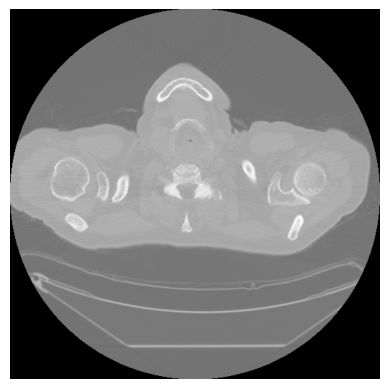

In [19]:
mostrar_dicom_por_indice(50)

In [ ]:
### Extracción de máscaras

Se seleccionan todos los ficheros de CT que están catalogados como segmentaciones de los tumores. Son lo que llamamos máscaras y nos sirven para identificar las masas tumorales en las imágenes. Estas segmentaciones nos permitirán realizar la extracción de características radiómicas. En total, se han logrado localizar 375 máscaras. Extraemos todas sus rutas dentro del dataset para luego poder acceder a ellas y sincronizarlas con los pacientes a los que correspondan.

In [22]:
mascaras = []

for root, dirs, files in os.walk(ruta_base):
    for nombre_dir in dirs:
        if "Tumor Segmentation" in nombre_dir:
            ruta_mascara = os.path.join(root, nombre_dir)
            partes = ruta_mascara.split(os.sep)
            try:
                idx = partes.index("RIDER Lung CT")
                paciente_id = partes[idx + 1]
                fecha_estudio = partes[idx + 2]
                mascara_nombre = partes[idx + 3]
            except Exception as e:
                print(f"⚠️ Error analizando ruta: {ruta_mascara}")
                continue
            mascaras.append({
                "Paciente": paciente_id,
                "Fecha_Estudio": fecha_estudio,
                "Nombre_Máscara": mascara_nombre,
                "Ruta_Máscara": ruta_mascara
            })

df_mascaras = pd.DataFrame(mascaras)

print(f"🧠 Se encontraron {len(df_mascaras)} máscaras.")
display(df_mascaras.head())
excel_path = os.path.join(ruta_base, "rutas_mascaras.xlsx")
df_mascaras.to_excel(excel_path, index=False)
print(f"✅ Archivo Excel guardado en:\n{excel_path}")

🧠 Se encontraron 375 máscaras.


,Paciente,Fecha_Estudio,Nombre_Máscara,Ruta_Máscara
0,RIDER-1129164940,09-05-2006-NA-NA-04592,2.000000-Tumor Segmentation-85043,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\2.000000-Tumor Segmentation-85043
1,RIDER-1129164940,09-05-2006-NA-NA-04592,3.000000-Tumor Segmentation-51791,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-05-2006-NA-NA-04592\3.000000-Tumor Segmentation-51791
2,RIDER-1129164940,09-19-2006-NA-NA-88216,10.000000-Tumor Segmentation-84466,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-19-2006-NA-NA-88216\10.000000-Tumor Segmentation-84466
3,RIDER-1129164940,09-19-2006-NA-NA-88216,100.000000-Tumor Segmentation-01562,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-19-2006-NA-NA-88216\100.000000-Tumor Segmentation-01562
4,RIDER-1129164940,09-19-2006-NA-NA-88216,101.000000-Tumor Segmentation-43650,C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\RIDER-1129164940\09-19-2006-NA-NA-88216\101.000000-Tumor Segmentation-43650


✅ Archivo Excel guardado en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\rutas_mascaras.xlsx


Se realiza el alineamiento de las máscaras a las imágenes a las que correspondan para ajustarlas a la geometría de la imagen CT de tórax. Además, se incluyen reescalados informáticos para permitir que las imágenes se correspondan en tamaño, origen y dirección con las máscaras. Se incorpora una rebinarización para aumentar la seguridad ante el aparecimiento de interpolaciones no previstas.

Se configura el extractor de características radiómicas. Se leen los CT y las máscaras y se ajustan tras expandirse a 3D s

Versión Final de Extracción de Características Radiómicas

In [40]:
def extraer_radiomica_pacientes(lista_pacientes):
    ruta_excel_mascaras = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\manifest-1719341001457\RIDER Lung CT\rutas_mascaras.xlsx"
    carpeta_salida = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos"
    os.makedirs(carpeta_salida, exist_ok=True)

    df_mascaras = pd.read_excel(ruta_excel_mascaras)
    df_mascaras["Paciente_ID"] = df_mascaras["Ruta_Máscara"].apply(
        lambda ruta: [p for p in ruta.split("\\") if p.startswith("RIDER-")][0]
    )

    def encontrar_ct_relacionada(ruta_estudio, carpeta_mascara):
        prefijo = carpeta_mascara.split("-")[0]
        carpetas = os.listdir(ruta_estudio)
        carpetas_ct = [c for c in carpetas if "Tumor Segmentation" not in c]
        posibles_ct = [c for c in carpetas_ct if c.startswith(prefijo)]
        if posibles_ct:
            return os.path.join(ruta_estudio, posibles_ct[0])
        return None

    for paciente in lista_pacientes:
        df_paciente = df_mascaras[df_mascaras["Paciente_ID"] == paciente]
        if df_paciente.empty:
            print(f"⚠️ No se encontraron rutas para el paciente {paciente}")
            continue

        resultados_totales = []

        for idx, fila in tqdm(df_paciente.iterrows(), total=len(df_paciente), desc=f"Extrayendo {paciente}"):
            try:
                ruta_mascara = fila["Ruta_Máscara"]
                nombre_carpeta_mascara = os.path.basename(ruta_mascara)
                ruta_estudio = os.path.dirname(ruta_mascara)
                ruta_ct = encontrar_ct_relacionada(ruta_estudio, nombre_carpeta_mascara)

                if ruta_ct is None:
                    print(f"❌ No se encontró CT correspondiente para: {ruta_mascara}")
                    continue

                reader = sitk.ImageSeriesReader()
                dicom_files = reader.GetGDCMSeriesFileNames(ruta_ct)
                reader.SetFileNames(dicom_files)
                imagen = reader.Execute()

                archivos_mascara = [os.path.join(ruta_mascara, f) for f in os.listdir(ruta_mascara) if f.endswith(".dcm")]
                if not archivos_mascara:
                    print(f"❌ No DICOMs en máscara: {ruta_mascara}")
                    continue

                mascara_2d = sitk.ReadImage(archivos_mascara[0])
                if mascara_2d.GetSize()[2] == 1:
                    nueva_mascara = sitk.Image(imagen.GetSize(), sitk.sitkUInt8)
                    nueva_mascara.CopyInformation(imagen)
                    z_pos = imagen.GetSize()[2] // 2
                    for y in range(mascara_2d.GetSize()[1]):
                        for x in range(mascara_2d.GetSize()[0]):
                            val = int(mascara_2d.GetPixel(x, y, 0))
                            if val > 0:
                                nueva_mascara.SetPixel(x, y, z_pos, 255)
                    mascara = nueva_mascara
                else:
                    mascara = mascara_2d

                def ajustar_mascara_a_imagen(imagen, mascara, valor_etiqueta=255):
                    if (
                        imagen.GetSize() != mascara.GetSize()
                        or imagen.GetSpacing() != mascara.GetSpacing()
                        or imagen.GetOrigin() != mascara.GetOrigin()
                        or imagen.GetDirection() != mascara.GetDirection()
                    ):
                        resample = sitk.ResampleImageFilter()
                        resample.SetOutputSpacing(imagen.GetSpacing())
                        resample.SetSize(imagen.GetSize())
                        resample.SetOutputDirection(imagen.GetDirection())
                        resample.SetOutputOrigin(imagen.GetOrigin())
                        resample.SetTransform(sitk.Transform())
                        resample.SetDefaultPixelValue(0)
                        resample.SetInterpolator(sitk.sitkNearestNeighbor)
                        mascara = resample.Execute(mascara)
                        mascara = sitk.BinaryThreshold(mascara, lowerThreshold=valor_etiqueta, upperThreshold=valor_etiqueta,
                                                       insideValue=valor_etiqueta, outsideValue=0)
                    return mascara

                mascara = ajustar_mascara_a_imagen(imagen, mascara)

                params = {
                    "setting": {
                        "binWidth": 25,
                        "resampledPixelSpacing": None,
                        "interpolator": "sitkBSpline",
                        "label": 255,
                        "normalize": False,
                        "removeOutliers": None,
                        "preCrop": False,
                        "padDistance": 5
                    },
                    "imageType": {
                        "Original": {},
                        "Wavelet": {},
                        "LoG": {"sigma": [1.0, 2.5, 5.0]},
                        "Square": {},
                        "SquareRoot": {},
                        "Logarithm": {},
                        "Exponential": {},
                        "Gradient": {},
                        "LBP2D": {},
                        "LBP3D": {}
                    },
                    "featureClass": {
                        "firstorder": [],
                        "shape": [],
                        "glcm": [],
                        "glrlm": [],
                        "glszm": [],
                        "gldm": [],
                        "ngtdm": []
                    }
                }

                extractor = featureextractor.RadiomicsFeatureExtractor(params)
                extractor.enableCExtensions = True

                resultados = extractor.execute(imagen, mascara, label=255)

                resultados_limpios = {
                    "Paciente": paciente,
                    "Ruta_CT": ruta_ct,
                    "Ruta_Máscara": ruta_mascara,
                    "Nombre_Mascara": nombre_carpeta_mascara
                }
                resultados_limpios.update(resultados)
                resultados_totales.append(resultados_limpios)

            except Exception as e:
                print(f"❌ Error en {paciente} -> {ruta_mascara}: {e}")

        df_final = pd.DataFrame(resultados_totales)
        nombre_archivo = f"resultados_radiomicos_{paciente.replace('RIDER-', '')}.xlsx"
        ruta_guardado = os.path.join(carpeta_salida, nombre_archivo)
        df_final.to_excel(ruta_guardado, index=False)
        print(f"\n📁 Archivo generado para {paciente} en:\n{ruta_guardado}")

In [41]:
extraer_radiomica_pacientes(pacientes)

Extrayendo RIDER-1129164940:   0%|                                                              | 0/22 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1129164940 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1129164940.xlsx


Extrayendo RIDER-1225316081:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1225316081 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1225316081.xlsx


Extrayendo RIDER-1286684383:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1286684383 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1286684383.xlsx


Extrayendo RIDER-1332496276:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1332496276 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1332496276.xlsx


Extrayendo RIDER-1344011628:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1344011628 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1344011628.xlsx


Extrayendo RIDER-1346917136:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1346917136 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1346917136.xlsx


Extrayendo RIDER-1500037140:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1500037140 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1500037140.xlsx


Extrayendo RIDER-1532432635:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1532432635 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1532432635.xlsx


Extrayendo RIDER-1760553574:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1760553574 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1760553574.xlsx


Extrayendo RIDER-1801720707:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1801720707 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1801720707.xlsx


Extrayendo RIDER-1825099523:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1825099523 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1825099523.xlsx


Extrayendo RIDER-1867199702:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-1867199702 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_1867199702.xlsx


Extrayendo RIDER-2016615262:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2016615262 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2016615262.xlsx


Extrayendo RIDER-2073083717:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2073083717 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2073083717.xlsx


Extrayendo RIDER-2151469008:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2151469008 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2151469008.xlsx


Extrayendo RIDER-2283289298:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2283289298 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2283289298.xlsx


Extrayendo RIDER-2357766186:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2357766186 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2357766186.xlsx


Extrayendo RIDER-2539508879:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2539508879 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2539508879.xlsx


Extrayendo RIDER-2541949645:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2541949645 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2541949645.xlsx


Extrayendo RIDER-2619750334:   0%|                                                              | 0/13 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2619750334 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2619750334.xlsx


Extrayendo RIDER-2655999012:   0%|                                                              | 0/10 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2655999012 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2655999012.xlsx


Extrayendo RIDER-2669524182:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2669524182 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2669524182.xlsx


Extrayendo RIDER-2799584460:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-2799584460 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_2799584460.xlsx


Extrayendo RIDER-3023568408:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-3023568408 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_3023568408.xlsx


Extrayendo RIDER-3115188676:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-3115188676 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_3115188676.xlsx


Extrayendo RIDER-3152132495:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-3152132495 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_3152132495.xlsx


Extrayendo RIDER-3160137230:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-3160137230 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_3160137230.xlsx


Extrayendo RIDER-5195703382:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-5195703382 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_5195703382.xlsx


Extrayendo RIDER-6324870494:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-6324870494 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_6324870494.xlsx


Extrayendo RIDER-8509201188:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-8509201188 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_8509201188.xlsx


Extrayendo RIDER-9762593735:   0%|                                                              | 0/11 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-9762593735 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_9762593735.xlsx


Extrayendo RIDER-9763310455:   0%|                                                              | 0/12 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum 


📁 Archivo generado para RIDER-9763310455 en:
C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos\resultados_radiomicos_9763310455.xlsx


In [ ]:
### Se crea los ficheros "POST" simulados y tras ello se configuran los existentes con _pre

In [43]:
carpeta = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos"
archivos = [f for f in os.listdir(carpeta) if f.endswith(".xlsx") and "_post" not in f]

def alterar_caracteristicas(df, factor_ruido=0.10):
    df_alterado = df.copy()
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    ruido = np.random.uniform(1 - factor_ruido, 1 + factor_ruido, size=df[columnas_numericas].shape)
    df_alterado[columnas_numericas] = df[columnas_numericas] * ruido
    return df_alterado

for archivo in tqdm(archivos, desc="Procesando archivos"):
    ruta_archivo = os.path.join(carpeta, archivo)
    nombre_base = os.path.splitext(archivo)[0]

    try:
        df = pd.read_excel(ruta_archivo)
        df_post = alterar_caracteristicas(df)
        nombre_post = f"{nombre_base}_post.xlsx"
        df_post.to_excel(os.path.join(carpeta, nombre_post), index=False)

    except Exception as e:
        print(f"❌ Error procesando {archivo}: {e}")

print("✅ Generación de archivos 'post' completada.")

Procesando archivos: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:46<00:00,  1.47s/it]

✅ Generación de archivos 'post' completada.


Se extraen todas las líneas correspondientes a características radiómicas de las imágenes tomadas que se corresponden con máscaras de segmentación. En total, tenemos ahora 32 pacientes. En algunos casos hay más de una imagen para un mismo paciente. Para amplificar el DataSet, vamos a extraer todas las imágenes de los pacientes para considerar cada una de las imágenes del mismo paciente (como ya tienen su pre y su post) como un paciente independiente. Por lo cual ahora buscaremos tener 375 pacientes (procedientes de imágenes reales) a partir de los 32 iniciales.

In [50]:
ruta_base = r"C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación"
ruta_entrada = os.path.join(ruta_base, "resultados_radiomicos_completos")
ruta_salida = os.path.join(ruta_base, "resultados_radiomicos_completos_datasetpacientes")
os.makedirs(ruta_salida, exist_ok=True)

for tipo in ['pre', 'post']:
    archivos = sorted([f for f in glob.glob(os.path.join(ruta_entrada, f'*_{tipo}.xlsx')) if not os.path.basename(f).startswith('~$')])
    print(f"Procesando {len(archivos)} archivos {tipo.upper()}...")

    for archivo in archivos:
        df = pd.read_excel(archivo)
        paciente_id = os.path.basename(archivo).replace("resultados_radiomicos_", "").replace(f"_{tipo}.xlsx", "")
        for idx, row in df.iterrows():
            ruta_ct = str(row['Ruta_CT']) if 'Ruta_CT' in df.columns else 'UNK'
            img_id = re.split(r"[\\/]", ruta_ct)[-1]
            img_id = re.sub(r"[^A-Za-z0-9\-\.]", "_", img_id)
            filename = f"resultados_radiomicos_{paciente_id}_{tipo}_seleccion_{img_id}.xlsx"
            path_out = os.path.join(ruta_salida, filename)
            row_df = pd.DataFrame([row])
            row_df.to_excel(path_out, index=False)
print(f"\n¡Ficheros individuales por selección generados en {ruta_salida}!")

Procesando 32 archivos PRE...
Procesando 32 archivos POST...

¡Ficheros individuales por selección generados en C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos_datasetpacientes!


In [ ]:
### Simulación de pacientes (1000) con PRE Y POST

En base a uno de los ficheros obtenidos, simulamos pacientes nuevos en su versión PRE y POST tratamiento

In [53]:
ruta_ficheros_reales = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos_datasetpacientes\resultados_radiomicos_1129164940_post_seleccion_2.000000-NA-01450.xlsx'
carpeta_ficheros_simulados = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_simuladas'

if not os.path.exists(carpeta_ficheros_simulados):
    os.makedirs(carpeta_ficheros_simulados)
df_real = pd.read_excel(ruta_ficheros_reales)

num_cols = []
elim_cols = []
for col in df_real.columns:
    try:
        _ = float(df_real[col].iloc[0])
        num_cols.append(col)
    except:
        elim_cols.append(col)

if elim_cols:
    print("Columnas eliminadas por no ser numéricas:", elim_cols)
df_real = df_real[num_cols]
feature_names = df_real.columns.tolist()

df_real = df_real.astype(float)

media = df_real.iloc[0].values
std = np.abs(media) * 0.15 + 1e-2  

N_SAMPLES = 1000

for i in range(N_SAMPLES):
    for fase in ['pre', 'post']:
        valores_sim = np.random.normal(loc=media, scale=std)
        df_sim = pd.DataFrame([valores_sim], columns=feature_names)
        filename = f"resultados_radiomicos_sim_{str(i).zfill(6)}_{fase}.xlsx"
        ruta_out = os.path.join(carpeta_ficheros_simulados, filename)
        df_sim.to_excel(ruta_out, index=False)
    if i % 100 == 0:
        print(f"Simulación {i} de {N_SAMPLES} generada...")

print(f"Se han creado {N_SAMPLES*2} archivos simulados en la carpeta: {carpeta_ficheros_simulados}")

Columnas eliminadas por no ser numéricas: ['Paciente', 'Ruta_CT', 'Ruta_Máscara', 'Nombre_Mascara', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass']
Simulación 0 de 1000 generada...
Simulación 100 de 1000 generada...
Simulación 200 de 1000 generada...
Simulación 300 de 1000 generada...
Simulación 400 de 1000 generada...
Simulación 500 de 1000 generada...
Simulación 600 de 1000 generada...
Simulación 700 de 1

In [ ]:
### Limpieza de columnas vacías o no numéricas de ficheros reales

In [54]:
ficheros_reales =r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\resultados_radiomicos_completos_datasetpacientes'
ficheros_reales_limpios = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_reales_limpios'

if not os.path.exists(ficheros_reales_limpios):
    os.makedirs(ficheros_reales_limpios)

archivos = [f for f in os.listdir(ficheros_reales) if f.endswith('.xlsx')]
print(f"Archivos encontrados: {len(archivos)}")

for archivo in archivos:
    ruta_in = os.path.join(ficheros_reales, archivo)
    ruta_out = os.path.join(ficheros_reales_limpios, archivo)
    try:
        df = pd.read_excel(ruta_in)
    except Exception as e:
        print(f'Error leyendo {archivo}: {e}')
        continue
    num_cols = []
    for col in df.columns:
        try:
            _ = float(df[col].iloc[0])
            num_cols.append(col)
        except:
            continue
    df_num = df[num_cols].astype(float)
    df_num.to_excel(ruta_out, index=False)
print(f"Se han creado los archivos limpios en: {ficheros_reales_limpios}")

Archivos encontrados: 750
Se han creado los archivos limpios en: C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_reales_limpios


In [ ]:
### Carga y unificación de ficheros

In [55]:
ficheros_reales_limpios = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_reales_limpios'
ficheros_simulados_limpios = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_simuladas'

def cargar_lote_xlsx(ruta_carpeta, tipo):
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.xlsx')]
    print(f"\n{tipo.upper()}: {len(archivos)} archivos encontrados en {ruta_carpeta}")
    data = []
    for archivo in archivos:
        ruta = os.path.join(ruta_carpeta, archivo)
        try:
            df_temp = pd.read_excel(ruta)
        except Exception as e:
            print(f"Error leyendo {archivo}: {e}")
            continue
        tokens = archivo.replace('.xlsx','').split('_')
        if tipo == 'real':
            paciente_id = tokens[2] if len(tokens) > 2 else 'unknown'
            fase = tokens[3] if len(tokens) > 3 else 'unknown'
            imagen_id = tokens[-1] if len(tokens) > 0 else 'unknown'
            df_temp['paciente_id'] = paciente_id
            df_temp['imagen_id'] = imagen_id
        else: # simulado
            sim_id = tokens[3] if len(tokens) > 3 else 'sim'
            fase = tokens[4] if len(tokens) > 4 else 'unknown'
            df_temp['sim_id'] = sim_id
        df_temp['fase'] = fase
        df_temp['origen'] = tipo
        data.append(df_temp)
    print(f"Archivos {tipo} cargados: {len(data)}")
    return data

reales_data = cargar_lote_xlsx(ficheros_reales_limpios, tipo='real')
simulados_data = cargar_lote_xlsx(ficheros_simulados_limpios, tipo='simulado')

df_reales = pd.concat(reales_data, ignore_index=True)
df_simulados = pd.concat(simulados_data, ignore_index=True)

print("\nDimensiones reales:", df_reales.shape)
print("Dimensiones simulados:", df_simulados.shape)
print("Primeras filas de reales:")
display(df_reales.head(2))
print("Primeras filas de simulados:")
display(df_simulados.head(2))

print("\nDistribución por fase (reales):")
print(df_reales['fase'].value_counts())
print("\nDistribución por fase (simulados):")
print(df_simulados['fase'].value_counts())


REAL: 750 archivos encontrados en C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_reales_limpios
Archivos real cargados: 750

SIMULADO: 2000 archivos encontrados en C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación\caracteristicas_radiomicas_simuladas
Archivos simulado cargados: 2000

Dimensiones reales: (750, 1697)
Dimensiones simulados: (2000, 1696)
Primeras filas de reales:


,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,lbp-2D_ngtdm_Busyness,lbp-2D_ngtdm_Coarseness,lbp-2D_ngtdm_Complexity,lbp-2D_ngtdm_Contrast,lbp-2D_ngtdm_Strength,paciente_id,imagen_id,fase,origen
0,-914.017969,-3304.638304,2971.329366,45772.058919,1.015858,0.761873,0.772008,39.432773,51.220739,54.291727,...,0.002041,0,914151.398710,0,0,0,1129164940,10.000000-NA-82412,post,real
1,-947.921874,-3078.454995,1818.399544,10270.994806,1.085134,0.583085,0.000000,0.000000,121.762469,71.269074,...,0.011763,0,956717.793141,0,0,0,1129164940,100.000000-NA-18882,post,real


Primeras filas de simulados:


,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis,lbp-2D_ngtdm_Busyness,lbp-2D_ngtdm_Coarseness,lbp-2D_ngtdm_Complexity,lbp-2D_ngtdm_Contrast,lbp-2D_ngtdm_Strength,sim_id,fase,origen
0,-933.496329,-2692.305713,1740.821367,6548.730900,0.725297,0.530052,0.006736,-0.004595,125.050199,58.590508,...,0.026870,0.029735,0.007894,9.250048e+05,-0.002424,0.005308,0.012168,000000,post,simulado
1,-1116.010487,-2354.299087,1511.962771,6757.875382,1.067950,0.483497,-0.013864,0.001768,137.782274,77.586992,...,0.026114,-0.000802,0.004268,1.021203e+06,-0.003227,0.008730,0.001449,000000,pre,simulado



Distribución por fase (reales):
fase
post    375
pre     375
Name: count, dtype: int64

Distribución por fase (simulados):
fase
post    1000
pre     1000
Name: count, dtype: int64


In [57]:
### Emparejamiento y cálculo de diferencias

In [56]:
def calcular_diferencias(df, id_col, extra_col=None):
    excl = [id_col, 'fase', 'origen']
    if extra_col: excl.append(extra_col)
    feature_cols = [col for col in df.columns if col not in excl]
    
    if extra_col:
        idx_cols = [id_col, extra_col]
    else:
        idx_cols = [id_col]
    df_pre = df[df['fase'] == 'pre'].set_index(idx_cols)
    df_post = df[df['fase'] == 'post'].set_index(idx_cols)

    # Solo pares que existen en ambos
    pares_validos = df_pre.index.intersection(df_post.index)
    df_pre = df_pre.loc[pares_validos]
    df_post = df_post.loc[pares_validos]
    print(f"Pares válidos encontrados: {len(pares_validos)}")
    
    df_pre = df_pre.sort_index()
    df_post = df_post.sort_index()
    
    df_diff = df_post[feature_cols].astype(float) - df_pre[feature_cols].astype(float)
    df_diff.columns = [f"{col}_diff" for col in feature_cols]
    # Añadir identificadores
    df_diff = df_diff.reset_index()
    return df_diff

# Diferencias para reales
df_reales_diff = calcular_diferencias(df_reales, id_col='paciente_id', extra_col='imagen_id')
print("\nPrimeras filas de diferencias (reales):")
display(df_reales_diff.head())

# Diferencias para simulados
df_simulados_diff = calcular_diferencias(df_simulados, id_col='sim_id')
print("\nPrimeras filas de diferencias (simulados):")
display(df_simulados_diff.head())


Pares válidos encontrados: 375

Primeras filas de diferencias (reales):


,paciente_id,imagen_id,diagnostics_Image-original_Mean_diff,diagnostics_Image-original_Minimum_diff,diagnostics_Image-original_Maximum_diff,diagnostics_Mask-original_VoxelNum_diff,diagnostics_Mask-original_VolumeNum_diff,original_shape_Elongation_diff,original_shape_Flatness_diff,original_shape_LeastAxisLength_diff,...,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis_diff,lbp-2D_gldm_LowGrayLevelEmphasis_diff,lbp-2D_gldm_SmallDependenceEmphasis_diff,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis_diff,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis_diff,lbp-2D_ngtdm_Busyness_diff,lbp-2D_ngtdm_Coarseness_diff,lbp-2D_ngtdm_Complexity_diff,lbp-2D_ngtdm_Contrast_diff,lbp-2D_ngtdm_Strength_diff
0,1129164940,10.000000-NA-82412,-16.362581,-280.638304,-84.670634,-1481.941081,0.015858,-0.071144,-0.002873,3.047974,...,-1.482974,0.022026,0.000034,-0.000099,0.000010,0.0,-85848.601290,0.0,0.0,0.0
1,1129164940,100.000000-NA-18882,65.089310,-54.454995,-66.600456,-743.005194,0.085134,0.030358,0.000000,0.000000,...,-4.737673,0.038163,0.000219,-0.000271,-0.001185,0.0,-43282.206859,0.0,0.0,0.0
2,1129164940,100.000000-NA-91224,-52.560508,-245.759795,-76.191310,-867.852572,-0.016760,-0.000085,0.000000,0.000000,...,7.103750,0.021668,0.000863,-0.000544,-0.000363,0.0,98224.238365,0.0,0.0,0.0
3,1129164940,101.000000-NA-34708,-6.337052,68.237134,-55.543596,807.965977,-0.035330,0.013988,0.000000,0.000000,...,-2.811704,0.081216,0.001025,-0.000400,-0.000353,0.0,-91193.865575,0.0,0.0,0.0
4,1129164940,103.000000-NA-53899,-31.042090,162.271176,21.036755,1440.529849,-0.063439,-0.009065,0.072126,-0.848861,...,-32.309225,-0.075679,-0.000246,0.000025,0.000167,0.0,-6070.465721,0.0,0.0,0.0


Pares válidos encontrados: 1000

Primeras filas de diferencias (simulados):


,sim_id,diagnostics_Image-original_Mean_diff,diagnostics_Image-original_Minimum_diff,diagnostics_Image-original_Maximum_diff,diagnostics_Mask-original_VoxelNum_diff,diagnostics_Mask-original_VolumeNum_diff,original_shape_Elongation_diff,original_shape_Flatness_diff,original_shape_LeastAxisLength_diff,original_shape_MajorAxisLength_diff,...,lbp-2D_gldm_LargeDependenceLowGrayLevelEmphasis_diff,lbp-2D_gldm_LowGrayLevelEmphasis_diff,lbp-2D_gldm_SmallDependenceEmphasis_diff,lbp-2D_gldm_SmallDependenceHighGrayLevelEmphasis_diff,lbp-2D_gldm_SmallDependenceLowGrayLevelEmphasis_diff,lbp-2D_ngtdm_Busyness_diff,lbp-2D_ngtdm_Coarseness_diff,lbp-2D_ngtdm_Complexity_diff,lbp-2D_ngtdm_Contrast_diff,lbp-2D_ngtdm_Strength_diff
0,000000,182.514159,-338.006626,228.858595,-209.144482,-0.342653,0.046555,0.020601,-0.006363,-12.732074,...,-4.674224,-0.190720,-0.024163,0.000757,0.030537,0.003626,-96198.313000,0.000802,-0.003422,0.010719
1,000001,-417.829316,-774.041020,345.854732,2529.886304,-0.126196,0.058899,0.013627,0.007443,33.307532,...,18.123335,0.147727,-0.013079,0.008817,-0.016210,-0.010860,108837.564486,-0.003870,0.006847,0.014458
2,000002,504.862985,-392.144045,25.719024,-645.409090,-0.083170,-0.049343,-0.015120,0.012041,-0.743754,...,2.845272,-0.275465,-0.015439,0.017103,0.030558,-0.009968,-160068.945192,0.001433,0.024647,0.000711
3,000003,193.689194,447.371888,-430.961803,1922.019104,0.044891,-0.066560,0.023802,0.015006,-7.460886,...,-5.736518,0.140031,-0.021492,-0.010243,0.006978,-0.004345,16986.351623,-0.018330,-0.007613,-0.011720
4,000004,123.290593,-1453.547363,38.645711,140.406499,-0.087095,0.095099,0.006944,0.006273,29.105039,...,-15.403740,-0.114308,-0.010455,-0.012637,0.021914,0.024647,198795.387388,0.012143,-0.008674,0.000060


In [ ]:
### Selección de características LITERATURA + CÁLCULO ESTADÍSTICO

Features seleccionadas según literatura: 525
['wavelet-LHL_firstorder_Maximum_diff', 'wavelet-HLL_glrlm_RunEntropy_diff', 'wavelet-LLL_glszm_SizeZoneNonUniformity_diff', 'original_glrlm_LongRunEmphasis_diff', 'log-sigma-1-0-mm-3D_firstorder_Mean_diff', 'lbp-2D_glszm_GrayLevelNonUniformity_diff', 'lbp-2D_ngtdm_Complexity_diff', 'gradient_gldm_SmallDependenceEmphasis_diff', 'wavelet-LHL_glszm_SizeZoneNonUniformity_diff', 'wavelet-HHL_glszm_ZoneEntropy_diff', 'original_gldm_LargeDependenceEmphasis_diff', 'squareroot_glcm_Idn_diff', 'logarithm_ngtdm_Strength_diff', 'wavelet-LHH_glcm_ClusterTendency_diff', 'wavelet-LHH_glszm_GrayLevelNonUniformity_diff', 'wavelet-LHH_glcm_Idm_diff', 'lbp-2D_firstorder_Minimum_diff', 'square_firstorder_Maximum_diff', 'wavelet-HLL_ngtdm_Contrast_diff', 'wavelet-LHL_glszm_ZoneEntropy_diff', 'wavelet-HHH_firstorder_Variance_diff', 'original_glcm_Idm_diff', 'wavelet-HHH_ngtdm_Complexity_diff', 'squareroot_gldm_DependenceEntropy_diff', 'original_firstorder_Entrop

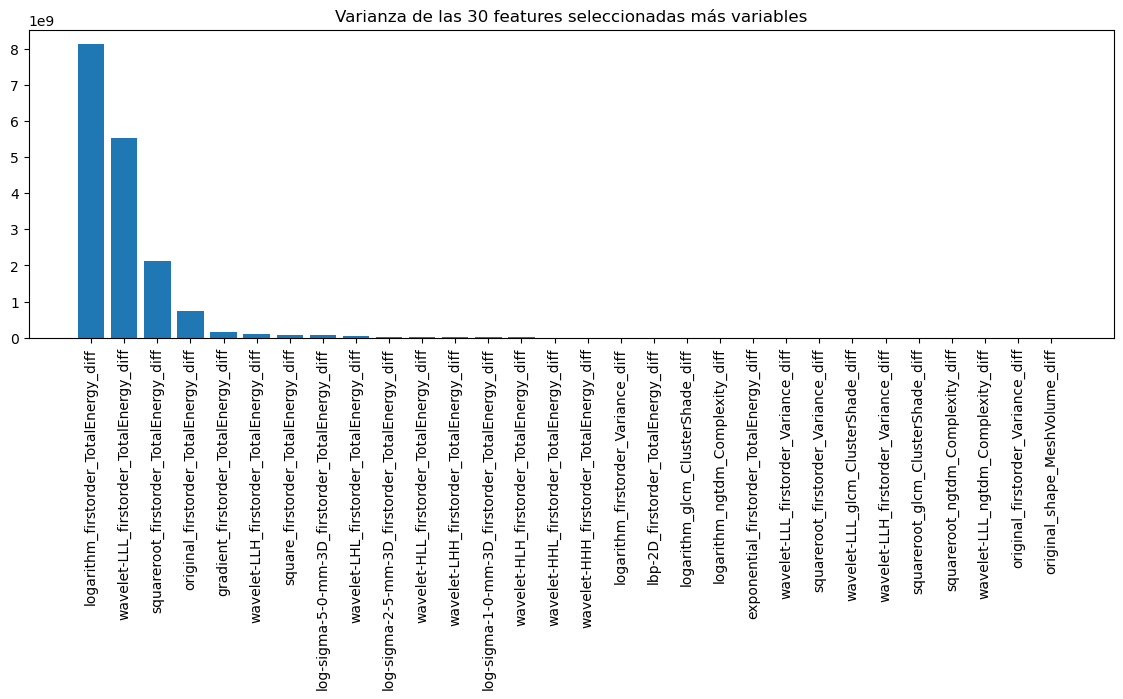

In [60]:
literatura_keywords = [
    "firstorder_Entropy_diff", "firstorder_Kurtosis_diff", "firstorder_Mean_diff", "firstorder_Median_diff",
    "firstorder_Minimum_diff", "firstorder_Maximum_diff", "firstorder_TotalEnergy_diff", "firstorder_Variance_diff",
    "shape_Sphericity_diff", "shape_SurfaceArea_diff", "shape_MeshVolume_diff",
    "glcm_Entropy_diff", "glcm_ClusterTendency_diff", "glcm_ClusterShade_diff", "glcm_Contrast_diff",
    "glcm_Correlation_diff", "glcm_DifferenceEntropy_diff", "glcm_DifferenceVariance_diff",
    "glcm_Idm_diff", "glcm_Idn_diff", "glcm_Imc1_diff",
    "glrlm_LongRunEmphasis_diff", "glrlm_ShortRunEmphasis_diff", "glrlm_RunEntropy_diff",
    "glszm_ZoneEntropy_diff", "glszm_SizeZoneNonUniformity_diff", "glszm_GrayLevelNonUniformity_diff",
    "gldm_DependenceEntropy_diff", "gldm_LargeDependenceEmphasis_diff", "gldm_SmallDependenceEmphasis_diff",
    "ngtdm_Contrast_diff", "ngtdm_Complexity_diff", "ngtdm_Strength_diff"
]

features_literatura = []
for col in df_reales_diff.columns:
    for keyword in literatura_keywords:
        if keyword in col:
            features_literatura.append(col)
features_literatura = list(set(features_literatura))  

print(f"Features seleccionadas según literatura: {len(features_literatura)}")
print(features_literatura)

N_TOP = 120 
features_seleccionadas = features_literatura.copy()

id_cols = [col for col in df_reales_diff.columns if col.endswith('_id')] + ['paciente_id', 'imagen_id']
features_num = [col for col in df_reales_diff.columns if col not in id_cols]

if len(features_seleccionadas) < N_TOP:
    stats = pd.DataFrame({
        "std": df_reales_diff[features_num].std(),
        "absmean": df_reales_diff[features_num].abs().mean()
    })
    stats["score"] = stats["std"] + stats["absmean"]  # Puedes cambiar el peso según criterio
    stats = stats.sort_values("score", ascending=False)
    for feat in stats.index:
        if feat not in features_seleccionadas:
            features_seleccionadas.append(feat)
        if len(features_seleccionadas) >= N_TOP:
            break

print(f"\nTotal de features seleccionadas (literatura + estadística): {len(features_seleccionadas)}")
print(features_seleccionadas[:15], "...")

with open('features_seleccionadas.txt', 'w') as f:
    for feat in features_seleccionadas:
        f.write(feat+'\n')

print("Lista guardada como 'features_seleccionadas.txt'")


top_vars = df_reales_diff[features_seleccionadas].std().sort_values(ascending=False)
plt.figure(figsize=(14,4))
plt.bar(top_vars.index[:30], top_vars.values[:30])
plt.title("Varianza de las 30 features seleccionadas más variables")
plt.xticks(rotation=90)
plt.show()

In [62]:
ruta_base = r'C:\Users\jesus\Desktop\TFM_JesúsVíasTorres_2025\Entregable_TFM\TFM_VíasTorresJesús_Experimentación'
ficheros_simulados = os.path.join(ruta_base, 'caracteristicas_radiomicas_simuladas')
N_FEATURES = 70 
PERCENTIL_RESP = 50  
RANDOM_STATE = 42

print("\n=== [FLAG] CARGA Y SELECCIÓN DE FEATURES ===")
with open(os.path.join(ruta_base, 'features_seleccionadas.txt'), 'r') as f:
    features_preseleccionadas = [line.strip() for line in f if line.strip()]

# -- Carga de simulados --
archivos = [f for f in os.listdir(ficheros_simulados) if f.endswith('.xlsx')]
simulados_data = []
for archivo in archivos:
    ruta = os.path.join(ficheros_simulados, archivo)
    df_temp = pd.read_excel(ruta)
    sim_id = archivo.split('_')[3]
    fase = archivo.split('_')[4].replace('.xlsx', '')
    df_temp['sim_id'] = sim_id
    df_temp['fase'] = fase
    simulados_data.append(df_temp)
df_sim = pd.concat(simulados_data, ignore_index=True)
pre = df_sim[df_sim['fase'] == 'pre'].set_index('sim_id')
post = df_sim[df_sim['fase'] == 'post'].set_index('sim_id')
common = pre.index.intersection(post.index)
pre = pre.loc[common]
post = post.loc[common]
valid_cols = [f.replace('_diff', '') for f in features_preseleccionadas if f.replace('_diff', '') in pre.columns]
X_diff_sim = post[valid_cols].astype(float).values - pre[valid_cols].astype(float).values
df_diff_sim = pd.DataFrame(X_diff_sim, columns=[c+'_diff' for c in valid_cols])
df_diff_sim['sim_id'] = common

features_final = df_diff_sim.drop('sim_id', axis=1).var().sort_values(ascending=False).head(N_FEATURES).index.tolist()
print(f"[FLAG] Features seleccionadas: {len(features_final)}")

# Umbrales (std) y vector binario
umbral_dict = {feat: df_diff_sim[feat].std() for feat in features_final}
bin_matrix = np.zeros(df_diff_sim[features_final].shape, dtype=int)
for i, feat in enumerate(features_final):
    bin_matrix[:, i] = (np.abs(df_diff_sim[feat]) >= umbral_dict[feat]).astype(int)
df_bin = pd.DataFrame(bin_matrix, columns=features_final)
df_bin['sim_id'] = df_diff_sim['sim_id'].values
df_bin['suma_1s'] = df_bin[features_final].sum(axis=1)
umbral_respuesta = np.percentile(df_bin['suma_1s'], PERCENTIL_RESP)
df_bin['respondedor'] = (df_bin['suma_1s'] >= umbral_respuesta).astype(int)

print("\n--- EJEMPLO DE VECTORES BINARIOS (primeras 5 imágenes) ---")
print(df_bin[features_final + ['respondedor']].head().to_string(index=False))
print(f"\n[INFO] Umbral respondedores (percentil {PERCENTIL_RESP}): {umbral_respuesta:.1f}")
print(df_bin['respondedor'].value_counts(normalize=True))


=== [FLAG] CARGA Y SELECCIÓN DE FEATURES ===
[FLAG] Features seleccionadas: 70

--- EJEMPLO DE VECTORES BINARIOS (primeras 5 imágenes) ---
 logarithm_firstorder_TotalEnergy_diff  wavelet-LLL_firstorder_TotalEnergy_diff  squareroot_firstorder_TotalEnergy_diff  original_firstorder_TotalEnergy_diff  square_firstorder_TotalEnergy_diff  wavelet-LLH_firstorder_TotalEnergy_diff  gradient_firstorder_TotalEnergy_diff  log-sigma-2-5-mm-3D_firstorder_TotalEnergy_diff  log-sigma-1-0-mm-3D_firstorder_TotalEnergy_diff  log-sigma-5-0-mm-3D_firstorder_TotalEnergy_diff  wavelet-HLL_firstorder_TotalEnergy_diff  wavelet-LHL_firstorder_TotalEnergy_diff  wavelet-HLH_firstorder_TotalEnergy_diff  wavelet-LHH_firstorder_TotalEnergy_diff  wavelet-HHL_firstorder_TotalEnergy_diff  wavelet-HHH_firstorder_TotalEnergy_diff  lbp-2D_firstorder_TotalEnergy_diff  wavelet-LLL_firstorder_Variance_diff  wavelet-LLL_glcm_ClusterShade_diff  squareroot_firstorder_Variance_diff  wavelet-LLH_firstorder_Variance_diff  original

In [ ]:
#MLP

In [66]:
print("MLP: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===")
X_bin = df_bin[features_final].values
y_bin = df_bin['respondedor'].values

mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32), alpha=0.12, max_iter=1000, early_stopping=True, n_iter_no_change=50, random_state=RANDOM_STATE, verbose=False)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_mlp = cross_validate(
    mlp, X_bin, y_bin, cv=cv,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'balanced_accuracy'],
    return_train_score=False
)
mlp.fit(X_bin, y_bin)
print("[MLP] Métricas de validación cruzada (media ± std):")
for metric in ['test_accuracy','test_f1','test_precision','test_recall','test_roc_auc','test_balanced_accuracy']:
    print(f"   {metric.replace('test_','').capitalize()}: {scores_mlp[metric].mean():.3f} ± {scores_mlp[metric].std():.3f}")

MLP: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===
[MLP] Métricas de validación cruzada (media ± std):
   Accuracy: 0.847 ± 0.025
   F1: 0.868 ± 0.021
   Precision: 0.861 ± 0.026
   Recall: 0.877 ± 0.020
   Roc_auc: 0.936 ± 0.018
   Balanced_accuracy: 0.842 ± 0.026


In [67]:
#Random Forest

In [68]:
print("\n=== RANDOM FOREST: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===")
rf = RandomForestClassifier(n_estimators=120, max_depth=8, min_samples_split=3, random_state=RANDOM_STATE)
scores_rf = cross_validate(
    rf, X_bin, y_bin, cv=cv,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'balanced_accuracy'],
    return_train_score=False
)
rf.fit(X_bin, y_bin)
print("[RF] Métricas de validación cruzada (media ± std):")
for metric in ['test_accuracy','test_f1','test_precision','test_recall','test_roc_auc','test_balanced_accuracy']:
    print(f"   {metric.replace('test_','').capitalize()}: {scores_rf[metric].mean():.3f} ± {scores_rf[metric].std():.3f}")


=== RANDOM FOREST: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===
[RF] Métricas de validación cruzada (media ± std):
   Accuracy: 0.783 ± 0.013
   F1: 0.830 ± 0.008
   Precision: 0.757 ± 0.017
   Recall: 0.918 ± 0.014
   Roc_auc: 0.876 ± 0.009
   Balanced_accuracy: 0.759 ± 0.016


In [ ]:
#XGBOOst

In [65]:
print("\n=== XGBOOST: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===")
xgb = XGBClassifier(n_estimators=120, max_depth=4, learning_rate=0.03, subsample=0.8, colsample_bytree=0.7, eval_metric='logloss', random_state=RANDOM_STATE)
scores_xgb = cross_validate(
    xgb, X_bin, y_bin, cv=cv,
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'balanced_accuracy'],
    return_train_score=False
)
xgb.fit(X_bin, y_bin)
print("[XGBoost] Métricas de validación cruzada (media ± std):")
for metric in ['test_accuracy','test_f1','test_precision','test_recall','test_roc_auc','test_balanced_accuracy']:
    print(f"   {metric.replace('test_','').capitalize()}: {scores_xgb[metric].mean():.3f} ± {scores_xgb[metric].std():.3f}")


=== XGBOOST: ENTRENAMIENTO Y VALIDACIÓN CRUZADA ===
[XGBoost] Métricas de validación cruzada (media ± std):
   Accuracy: 0.776 ± 0.008
   F1: 0.821 ± 0.007
   Precision: 0.760 ± 0.013
   Recall: 0.894 ± 0.025
   Roc_auc: 0.863 ± 0.008
   Balanced_accuracy: 0.755 ± 0.009


In [ ]:
### Test con simulados y reales

In [69]:
print("\n=== TEST CON 1000 SIMULADOS NUEVOS ===")
# ---- 1000 simulados nuevos ----
n_test = 1000
np.random.seed(123)
media_sim = X_bin.mean(axis=0)
X_test_bin = np.random.binomial(1, media_sim, (n_test, len(features_final)))
suma_test = X_test_bin.sum(axis=1)
umbral_test = np.percentile(suma_test, PERCENTIL_RESP)
y_test = (suma_test >= umbral_test).astype(int)
print("Distribución y_test simulados:", pd.Series(y_test).value_counts(normalize=True))

def eval_all(y_true, y_pred, nombre):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    if len(np.unique(y_true)) < 2:
        rocauc = float('nan')
        print(f"[WARNING] Solo una clase en y_true. ROC_AUC no calculable.")
    else:
        rocauc = roc_auc_score(y_true, y_pred)
    print(f"{nombre} - Simulados: Accuracy={acc:.3f}, F1={f1:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, ROC_AUC={rocauc if not np.isnan(rocauc) else 'NA'}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return [acc, f1, prec, rec, rocauc]

metrics_mlp_sim = eval_all(y_test, mlp.predict(X_test_bin), "MLP")
metrics_rf_sim  = eval_all(y_test,  rf.predict(X_test_bin),  "Random Forest")
metrics_xgb_sim = eval_all(y_test, xgb.predict(X_test_bin),  "XGBoost")


=== TEST CON 1000 SIMULADOS NUEVOS ===
Distribución y_test simulados: 1    0.576
0    0.424
Name: proportion, dtype: float64
MLP - Simulados: Accuracy=0.883, F1=0.901, Precision=0.881, Recall=0.922, ROC_AUC=0.8760318396226416
Confusion matrix:
 [[352  72]
 [ 45 531]]
Random Forest - Simulados: Accuracy=0.769, F1=0.821, Precision=0.741, Recall=0.920, ROC_AUC=0.7419090670859538
Confusion matrix:
 [[239 185]
 [ 46 530]]
XGBoost - Simulados: Accuracy=0.788, F1=0.830, Precision=0.772, Recall=0.898, ROC_AUC=0.7683601939203353
Confusion matrix:
 [[271 153]
 [ 59 517]]


In [70]:
archivos_real = [f for f in os.listdir(ficheros_reales_limpios) if f.endswith('.xlsx')]
real_data = []
for archivo in archivos_real:
    df_temp = pd.read_excel(os.path.join(ficheros_reales_limpios, archivo))
    toks = archivo.replace('.xlsx', '').split('_')
    paciente_id = toks[2]
    fase = toks[3]
    imagen_id = toks[-1]
    df_temp['paciente_id'] = paciente_id
    df_temp['fase'] = fase
    df_temp['imagen_id'] = imagen_id
    real_data.append(df_temp)
df_real = pd.concat(real_data, ignore_index=True)
pre_real = df_real[df_real['fase'] == 'pre'].set_index(['paciente_id', 'imagen_id'])
post_real = df_real[df_real['fase'] == 'post'].set_index(['paciente_id', 'imagen_id'])
idx_real = pre_real.index.intersection(post_real.index)
X_diff_real = post_real[[f.replace('_diff','') for f in features_final]].astype(float).values - pre_real[[f.replace('_diff','') for f in features_final]].astype(float).values
df_diff_real = pd.DataFrame(X_diff_real, columns=features_final)
df_diff_real['paciente_id'] = [idx[0] for idx in idx_real]
df_diff_real['imagen_id'] = [idx[1] for idx in idx_real]
bin_matrix_real = np.zeros(df_diff_real[features_final].shape, dtype=int)
for i, feat in enumerate(features_final):
    bin_matrix_real[:, i] = (np.abs(df_diff_real[feat]) >= umbral_dict[feat]).astype(int)
df_bin_real = pd.DataFrame(bin_matrix_real, columns=features_final)
df_bin_real['paciente_id'] = df_diff_real['paciente_id'].values
df_bin_real['imagen_id'] = df_diff_real['imagen_id'].values
df_bin_real['suma_1s'] = df_bin_real[features_final].sum(axis=1)
df_bin_real['respondedor'] = (df_bin_real['suma_1s'] >= umbral_respuesta).astype(int)
print("Distribución respondedores en reales:", df_bin_real['respondedor'].value_counts(normalize=True))
X_bin_real = df_bin_real[features_final].values
y_real = df_bin_real['respondedor'].values

metrics_mlp_real = eval_all(y_real, mlp.predict(X_bin_real), "MLP")
metrics_rf_real  = eval_all(y_real, rf.predict(X_bin_real), "Random Forest")
metrics_xgb_real = eval_all(y_real, xgb.predict(X_bin_real), "XGBoost")

Distribución respondedores en reales: respondedor
0    0.84
1    0.16
Name: proportion, dtype: float64
MLP - Simulados: Accuracy=0.992, F1=0.976, Precision=0.952, Recall=1.000, ROC_AUC=0.9952380952380953
Confusion matrix:
 [[312   3]
 [  0  60]]
Random Forest - Simulados: Accuracy=0.941, F1=0.843, Precision=0.738, Recall=0.983, ROC_AUC=0.9583333333333334
Confusion matrix:
 [[294  21]
 [  1  59]]
XGBoost - Simulados: Accuracy=0.955, F1=0.864, Precision=0.831, Recall=0.900, ROC_AUC=0.9325396825396824
Confusion matrix:
 [[304  11]
 [  6  54]]


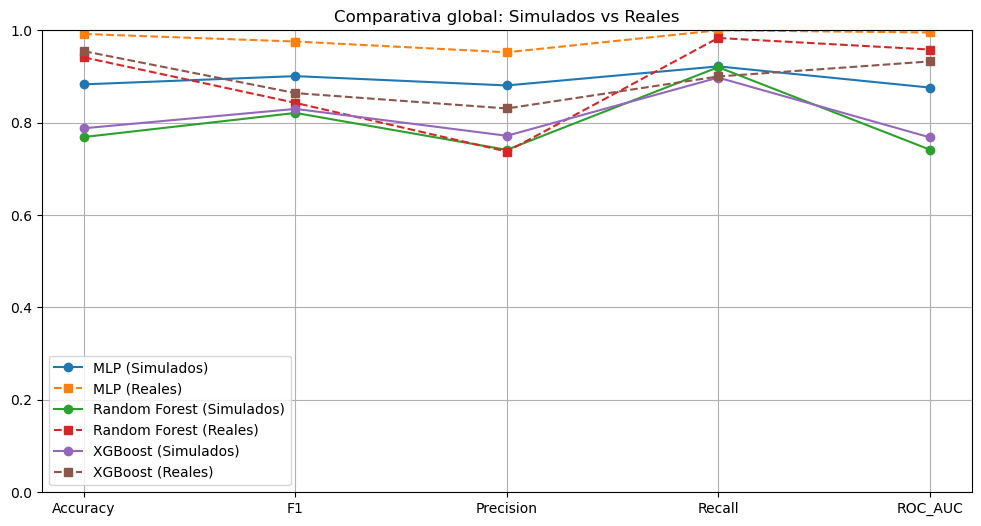

In [71]:
labels = ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC_AUC']

arr_sim = np.array([metrics_mlp_sim, metrics_rf_sim, metrics_xgb_sim])
arr_real = np.array([metrics_mlp_real, metrics_rf_real, metrics_xgb_real])
plt.figure(figsize=(12,6))
for i, name in enumerate(['MLP','Random Forest','XGBoost']):
    plt.plot(labels, arr_sim[i], marker='o', label=f'{name} (Simulados)')
    plt.plot(labels, arr_real[i], marker='s', linestyle='--', label=f'{name} (Reales)')
plt.ylim(0,1)
plt.title("Comparativa global: Simulados vs Reales")
plt.legend()
plt.grid(True)
plt.show()

In [72]:
res_dict = {
    "Modelo": ["MLP", "Random Forest", "XGBoost"],
    "Acc_test_sim": [metrics_mlp_sim[0], metrics_rf_sim[0], metrics_xgb_sim[0]],
    "F1_test_sim":  [metrics_mlp_sim[1], metrics_rf_sim[1], metrics_xgb_sim[1]],
    "Prec_test_sim":[metrics_mlp_sim[2], metrics_rf_sim[2], metrics_xgb_sim[2]],
    "Rec_test_sim": [metrics_mlp_sim[3], metrics_rf_sim[3], metrics_xgb_sim[3]],
    "ROC_AUC_test_sim": [metrics_mlp_sim[4], metrics_rf_sim[4], metrics_xgb_sim[4]],
    "Acc_test_real": [metrics_mlp_real[0], metrics_rf_real[0], metrics_xgb_real[0]],
    "F1_test_real":  [metrics_mlp_real[1], metrics_rf_real[1], metrics_xgb_real[1]],
    "Prec_test_real":[metrics_mlp_real[2], metrics_rf_real[2], metrics_xgb_real[2]],
    "Rec_test_real": [metrics_mlp_real[3], metrics_rf_real[3], metrics_xgb_real[3]],
    "ROC_AUC_test_real": [metrics_mlp_real[4], metrics_rf_real[4], metrics_xgb_real[4]],
}
df_out = pd.DataFrame(res_dict)
df_out.to_csv("resultados_binarios_comparativa_extensa.csv", index=False)
print("[FLAG] Resultados comparativos exportados en 'resultados_binarios_comparativa_extensa.csv'")

[FLAG] Resultados comparativos exportados en 'resultados_binarios_comparativa_extensa.csv'



=== [CURVAS ROC Y MATRICES DE CONFUSIÓN EN TEST SIMULADOS] ===


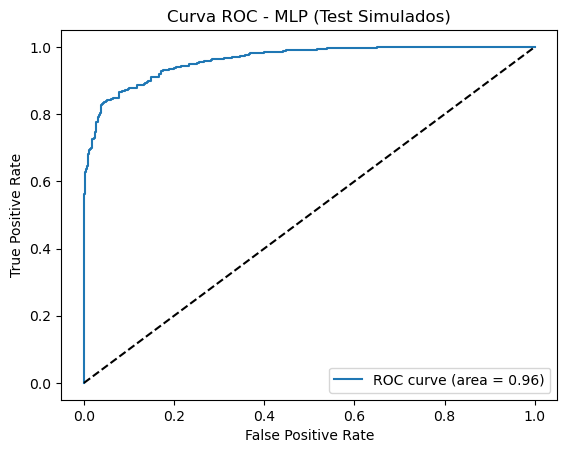

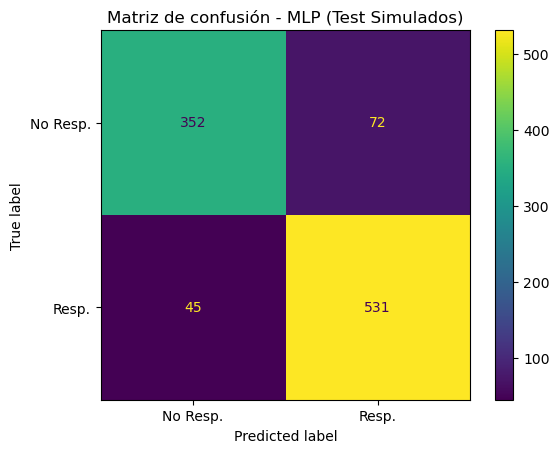

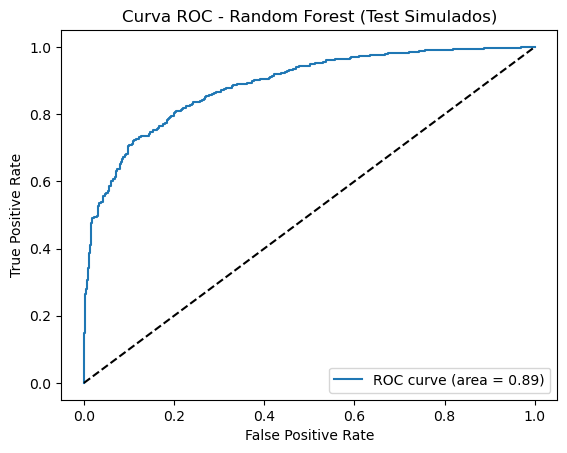

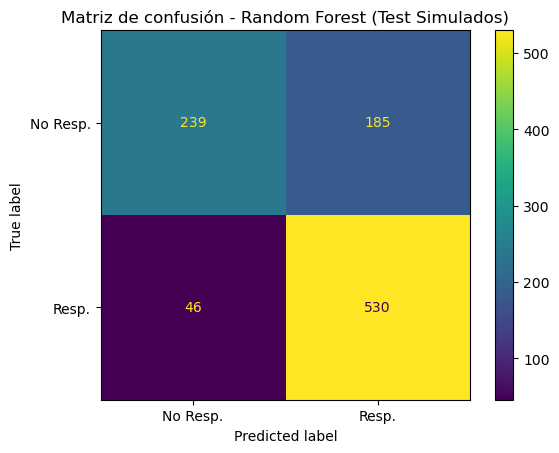

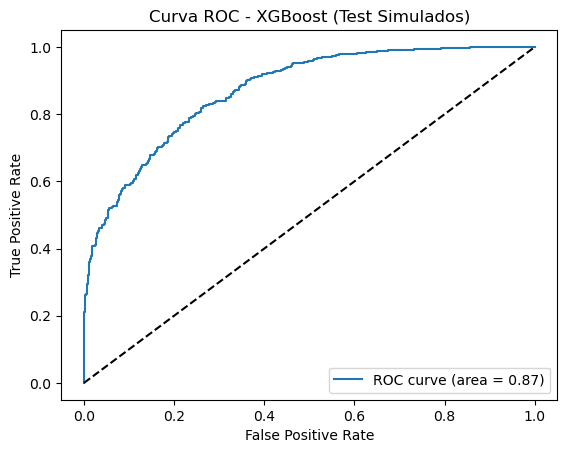

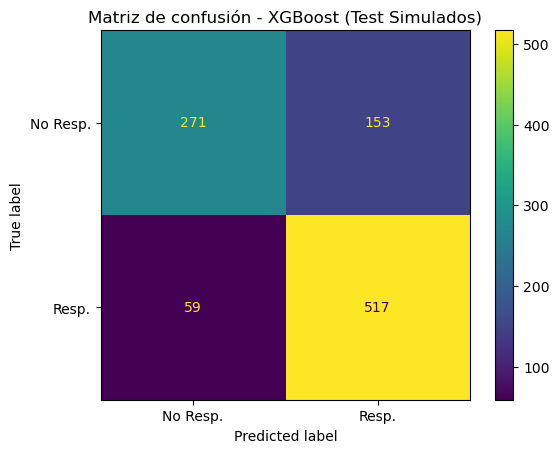


=== [CURVAS ROC Y MATRICES DE CONFUSIÓN EN REALES] ===


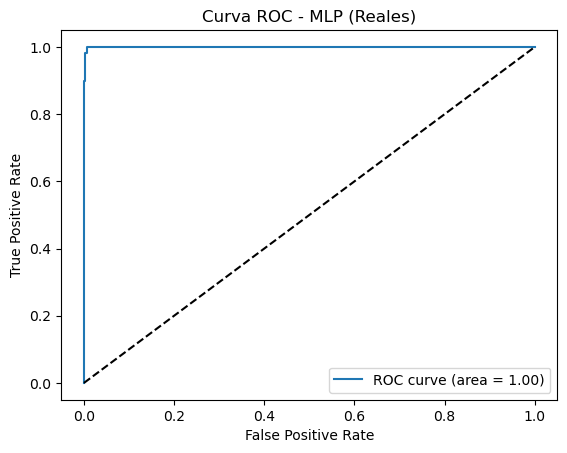

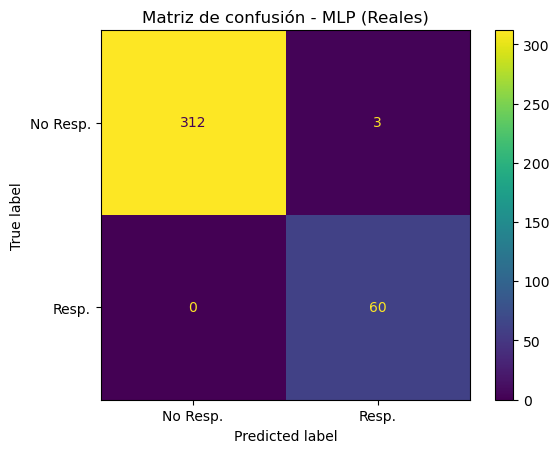

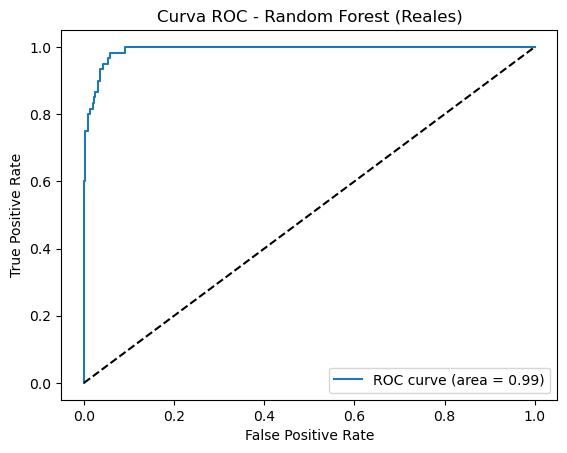

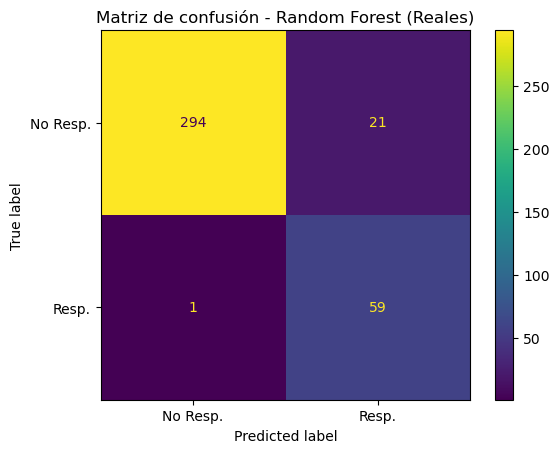

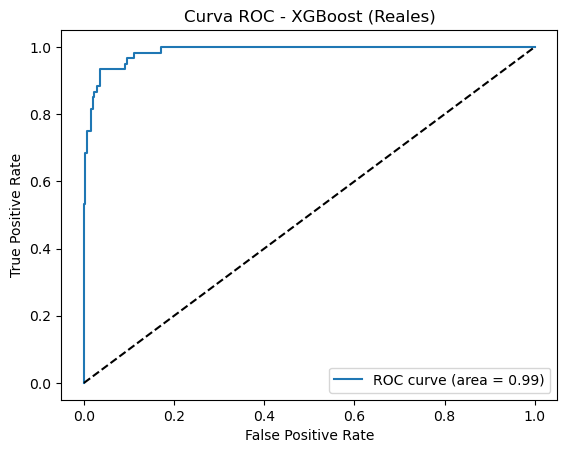

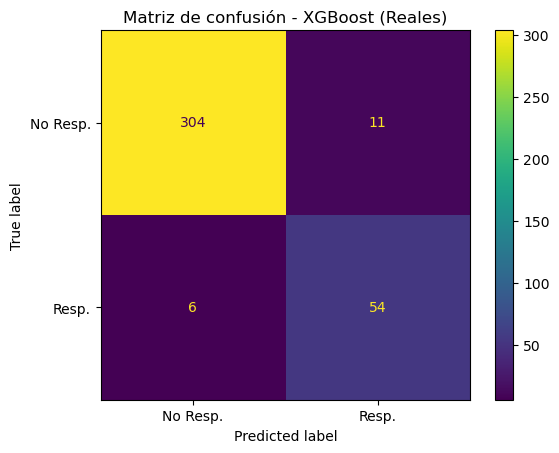

In [73]:
print("\n=== [CURVAS ROC Y MATRICES DE CONFUSIÓN EN TEST SIMULADOS] ===")
y_true = y_test
for nombre, modelo in zip(["MLP", "Random Forest", "XGBoost"], [mlp, rf, xgb]):
    y_pred = modelo.predict(X_test_bin)
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test_bin)[:,1]
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test_bin)
    else:
        y_score = y_pred
    # ROC curve
    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre} (Test Simulados)")
        plt.legend(loc="lower right")
        plt.show()
    # Confusión
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["No Resp.","Resp."])
    plt.title(f"Matriz de confusión - {nombre} (Test Simulados)")
    plt.show()

print("\n=== [CURVAS ROC Y MATRICES DE CONFUSIÓN EN REALES] ===")
y_true = y_real
for nombre, modelo in zip(["MLP", "Random Forest", "XGBoost"], [mlp, rf, xgb]):
    y_pred = modelo.predict(X_bin_real)
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_bin_real)[:,1]
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_bin_real)
    else:
        y_score = y_pred
    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre} (Reales)")
        plt.legend(loc="lower right")
        plt.show()
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["No Resp.","Resp."])
    plt.title(f"Matriz de confusión - {nombre} (Reales)")
    plt.show()